<a href="https://colab.research.google.com/github/kyle-gao/ML_ipynb/blob/master/K_fold_validation_and_bagging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright 2020 Yi Lin(Kyle) Gao

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 .

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

# Dataset preparation functions
For k-fold cross-validation, we make use of the tf.data.Dataset(split) to split the training dataset into k splits.

We create k (train_ds,test_ds) pairs. The ith pair's test_ds is the ith split. The ith pair's train_ds consists of the other k-1 splits.

Figure 3. in Ren, Qiubing & Li, Mingchao & Han, Shuai. (2019). Tectonic discrimination of olivine in basalt using data mining techniques based on major elements: a comparative study from multiple perspectives. Big Earth Data. 1-18. 10.1080/20964471.2019.1572452. 

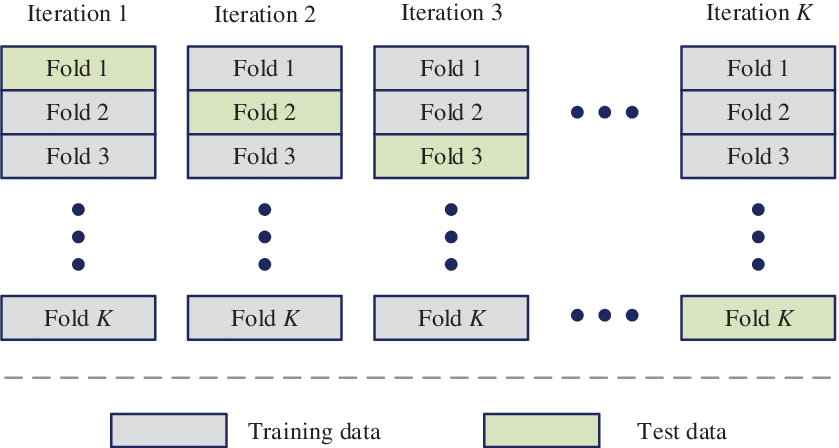

In [ ]:
def make_splits(k, length):
  """
  Returns a list of k strings of format ["train[0:length/k]", "train[length/k:2*length/k]"...]

  """
  return [f"train[{int(a*length/k)}:{int((a+1)*length/k)}]" for a in range(k)]

In [ ]:
def concatenate_ds_list (ds_list):
  """
  Returns the concatenantion of a list of tf.data.Dataset
  
  """
  concat_ds = ds_list[0]
  for i in range(1,len(ds_list)):
    concat_ds = concat_ds.concatenate(ds_list[i])
  return concat_ds

def make_k_pairs (split_list):
  """Returns a list of (train_dataset, test_dataset) from a list of k datasets
  - train_dataset is (k-1) times longer than test_dataset
  - these are tf.data.Dataset objects
  """
  k_pairs = []
  for i in  range(len(split_list)):
    copy_split=split_list.copy()
    test_dataset = copy_split.pop(i) #for k splits, the first one becomes test_dataset
    train_dataset = concatenate_ds_list(copy_split)
    k_pairs.append((train_dataset, test_dataset))
  return k_pairs

In [ ]:
"""#Testing
splits = [tf.data.Dataset.range(3*i,3*(i+1)) for i in range(0,3)]
k_splits = make_k_pairs(splits)
k_splits =[(list(train),list(val)) for (train,val) in k_splits]
k_splits[0]"""

'#Testing\nsplits = [tf.data.Dataset.range(3*i,3*(i+1)) for i in range(0,3)]\nk_splits = make_k_pairs(splits)\nk_splits =[(list(train),list(val)) for (train,val) in k_splits]\nk_splits[0]'

In [ ]:
"""
train, test = k_pairs[0]
train = train.shuffle(1024).batch(16).map(norm).prefetch(tf.data.experimental.AUTOTUNE)
test = test.batch(16)
model = make_model()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = metrics)
model.summary()"""

"\ntrain, test = k_pairs[0]\ntrain = train.shuffle(1024).batch(16).map(norm).prefetch(tf.data.experimental.AUTOTUNE)\ntest = test.batch(16)\nmodel = make_model()\nmodel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = metrics)\nmodel.summary()"

Model definition

In [ ]:
def make_model():
  
  model=tf.keras.models.Sequential([
                                    tf.keras.layers.Conv2D(input_shape=(28, 28, 1), kernel_size = 3,filters = 16),
                                    tf.keras.layers.MaxPool2D(),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(units = 10, activation = 'softmax')
                                   
  ])
  
  return model

# Training

In [ ]:
def cross_validate(optimizer, epochs = 2):
  """
  Performs k-fold cross-validation for a given lr. Returns a list of models (tf.Models) and an accuracy (float).
  """
  models = []
  accuracies = []

  def norm(data,label):
    return tf.cast(data, tf.float32)/255.0, label

  for i in range(k):

    train, test = k_pairs[i]
    train = train.shuffle(1024).batch(16).map(norm).prefetch(tf.data.experimental.AUTOTUNE)
    test = test.batch(16).map(norm)

    model = make_model()
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics = ['acc'])
    model.fit(train, epochs = epochs, verbose = False)

    models.append(model)
    accuracy = model.evaluate(test, return_dict= True, verbose = False)['acc']
    accuracies.append(accuracy)

    print("Fold: ", i+1," Validation accuracy: ", accuracy)

  return models, np.mean(accuracies)

In [ ]:
def search_parameters(k, lr_list, num_examples = 6000):
  """
  Performs k-fold cross-validation for a list of learning rates. 
  Returns a list of models (tf.Models) and cross-validation accuracy(float)
  for the learning rate with the highest cross-validation accuracy.

  """

  splits = make_splits(k+1, num_examples)
  split_list = tfds.load('fashion_mnist', split = splits, as_supervised=True)
  k_pairs = make_k_pairs(split_list)
     
  saved_acc = 0
  saved_models = None
  for lr in lr_list:
    optimizer = tf.optimizers.Adam(lr)
    models, cross_accuracy = cross_validate(optimizer, epochs = 2)
    if cross_accuracy > saved_acc:
      saved_acc = cross_accuracy
      saved_models = models
  return models, saved_acc


In [ ]:
lr_list = (0.001, 0.0003, 0.0001)
models, saved_acc = search_parameters(k, lr_list)

Fold:  1  Validation accuracy:  0.8270000219345093
Fold:  2  Validation accuracy:  0.8460000157356262
Fold:  3  Validation accuracy:  0.878000020980835
Fold:  4  Validation accuracy:  0.8379999995231628
Fold:  5  Validation accuracy:  0.8379999995231628
Fold:  6  Validation accuracy:  0.8460000157356262
Fold:  1  Validation accuracy:  0.7910000085830688
Fold:  2  Validation accuracy:  0.8299999833106995
Fold:  3  Validation accuracy:  0.8420000076293945
Fold:  4  Validation accuracy:  0.7950000166893005
Fold:  5  Validation accuracy:  0.8230000138282776
Fold:  6  Validation accuracy:  0.8050000071525574
Fold:  1  Validation accuracy:  0.7369999885559082
Fold:  2  Validation accuracy:  0.8040000200271606
Fold:  3  Validation accuracy:  0.7870000004768372
Fold:  4  Validation accuracy:  0.75
Fold:  5  Validation accuracy:  0.7839999794960022
Fold:  6  Validation accuracy:  0.7630000114440918


In [ ]:
test_ds = tfds.load('fashion_mnist', split = "test[:10%]", as_supervised=True)
test_ds = test_ds.batch(16)

We evaluate the saved models on a dataset not seen during training.

In [ ]:
evaluation = np.mean([model.evaluate(test_ds, return_dict= True, verbose = False)['acc'] for model in models])
print("The mean accuracy on the test set is: ",evaluation)

The mean accuracy on the test set is:  0.7385000089804331


# Prediction
We can average the predictions of the models.

In [ ]:
x = tfds.load('fashion_mnist', split = "test[:10%]", as_supervised=True)
x = x.batch(1)
x = x.take(1)

In [ ]:
prediction = np.asarray([model.predict(x)[0] for model in models])

In [ ]:
def models_predict(x, models):
  prediction = np.asarray([model.predict(x) for model in models])
  return np.mean(prediction, axis= 0)

In [ ]:
models_predict(x, models)

array([[0.0000000e+00, 0.0000000e+00, 2.9709533e-08, 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)